In [1]:
!pip install pytorch-lightning

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import tensorflow as tf

## Установка random_seed

In [3]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## Архитектура AlexNet

In [4]:
class AlexNet(pl.LightningModule):
    def __init__(self, num_classes=100, lr=0.001):
        super(AlexNet, self).__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=2),
            nn.BatchNorm2d(32),  # Добавлено Batch Normalization
            nn.LeakyReLU(inplace=True),  # Заменено на LeakyReLU
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(32, 96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Определяем размер выхода после features
        test_input = torch.zeros(1, 3, 224, 224)
        output_size = self._get_conv_output_size(test_input)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Увеличен Dropout
            nn.Linear(output_size, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(inplace=True),

            nn.Dropout(p=0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(inplace=True),

            nn.Linear(1024, num_classes),
        )
        self.criterion = nn.CrossEntropyLoss()

    def _get_conv_output_size(self, x):
        x = self.features(x)
        return int(torch.flatten(x, 1).size(1))

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels).item() / labels.size(0)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.lr, steps_per_epoch=100, epochs=10
        )  # Cyclical Learning Rate
        return [optimizer], [scheduler]


## Подготовка данных

In [5]:
def prepare_data():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

## Основной код

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader, test_loader = prepare_data()

model = AlexNet(num_classes=100, lr=0.001)

logger = TensorBoardLogger("./lightning_logs", name="alexnet", log_graph=True)
trainer = pl.Trainer(
    max_epochs=10,
    log_every_n_steps=10,  # Логирование каждые 10 шагов
    logger=logger,
    enable_progress_bar=True,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)




Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | features   | Sequential       | 568 K  | train
1 | classifier | Sequential       | 46.5 M | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
47.1 M    Trainable params
0         Non-trainable params
47.1 M    Total params
188.319   Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/tensorboard.py:195: Could not log computational

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5022000074386597     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5022000074386597}]

## Визуализация

In [12]:
def plot_metrics(log_dir):
    # Найти последнюю версию
    version_dirs = sorted(glob.glob(os.path.join(log_dir, "version_*")), key=lambda x: int(x.split("_")[-1]))
    if not version_dirs:
        print(f"Логи не найдены в директории: {log_dir}")
        return

    latest_version = version_dirs[-1]
    print(f"Используется директория версии: {latest_version}")

    event_files = glob.glob(os.path.join(latest_version, "events.out.tfevents.*"))
    if not event_files:
        print(f"Файл событий не найден в директории: {latest_version}")
        return

    event_file = event_files[-1]
    print(f"Найден файл событий: {event_file}")

    # Инициализация словаря для хранения метрик
    metrics = {}

    # Использование tf.data для чтения событий
    try:
        for event in tf.data.TFRecordDataset(event_file):
            event = tf.compat.v1.Event.FromString(event.numpy())
            if event.summary.value:
                for value in event.summary.value:
                    tag = value.tag
                    step = event.step

                    # Для простых скалярных значений сохраняем метрики
                    if value.HasField("simple_value"):
                        scalar_value = value.simple_value

                        # Сохраняем данные для каждого тега
                        if tag not in metrics:
                            metrics[tag] = []
                        metrics[tag].append((step, scalar_value))
    except Exception as e:
        print(f"Ошибка при чтении событий: {e}")
        return

    # Построение графиков для всех метрик
    for key, data in metrics.items():
        steps, values = zip(*data)
        if len(steps) > 1:  # Построить график только если больше одной точки
            plt.figure(figsize=(10, 6))
            plt.plot(steps, values, label=key)
            plt.xlabel("Steps")
            plt.ylabel("Value")
            plt.legend()
            plt.title(f"Metric: {key}")
            plt.show()
        else:
            print(f"Недостаточно данных для построения графика для ключа: {key}")


Используется директория версии: ./lightning_logs/alexnet/version_2
Найден файл событий: ./lightning_logs/alexnet/version_2/events.out.tfevents.1737482671.e355d2a6a32c.1871.2
Недостаточно данных для построения графика для ключа: hp_metric


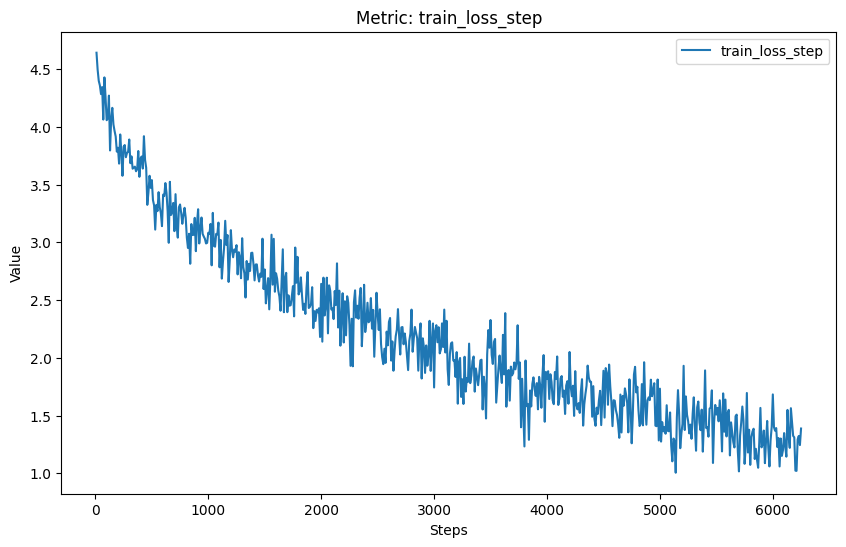

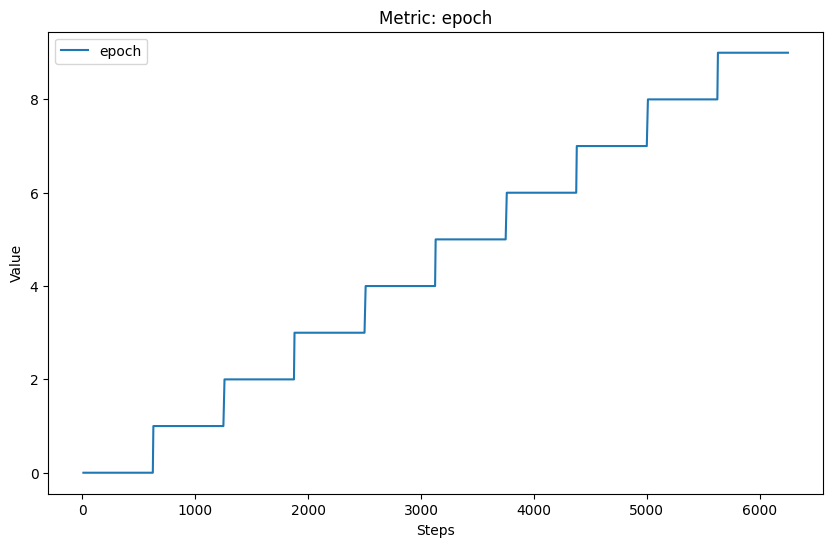

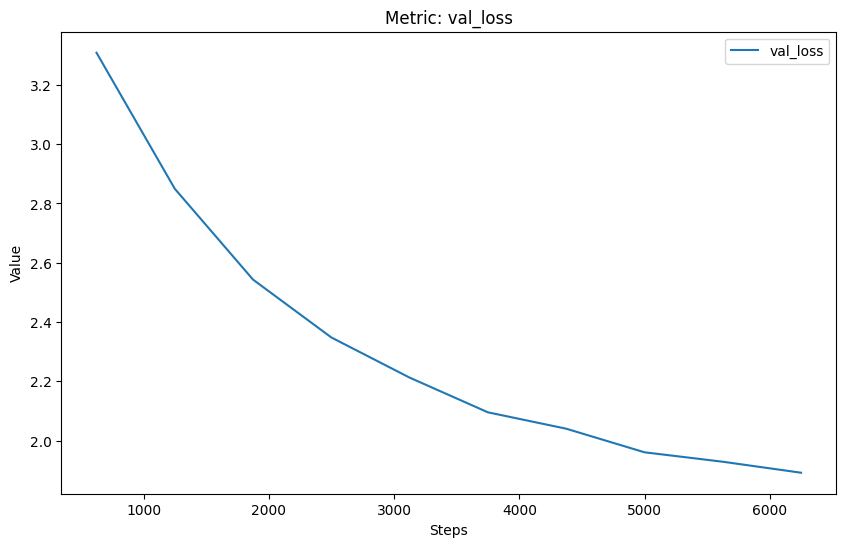

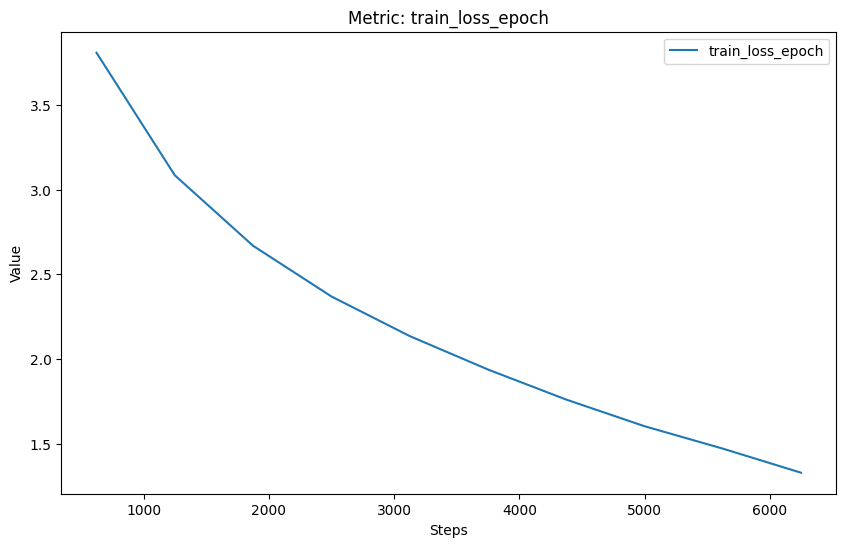

In [13]:
# Plot metrics
plot_metrics("./lightning_logs/alexnet")

P.S. были проблемы с чтением логов, поэтому там затесался график эпох

# Анализ обучения

## Графики

### Train Loss (по шагам)
- Потери на тренировке заметно снижаются, что указывает на стабильное обучение.
- Несмотря на общее снижение, график "зубчатый". Это может быть вызвано:
  - Использованием небольшого батча.
  - Высокой вариативностью данных.

### Validation Loss
- Потери на валидации плавно снижаются на протяжении всех шагов.
- Это подтверждает, что модель улучшает свои обобщающие способности и не переобучается даже на 10 эпохах.

### Train Loss (по эпохам)
- График показывает последовательное снижение потерь по эпохам.
- Обучение идет в правильном направлении: с увеличением числа эпох модель становится более точной.

### Тестовая точность
- **Точность на тесте**: `0.5022` (50.22%).
- С увеличением эпох и подбором параметров результат может быть улучшен

P.P.S на графиках видна сходимость, поэтому не стал доводить до 80-90%